<a href="https://www.kaggle.com/code/idiotprofessor/time-series-using-arima-and-sarimax?scriptVersionId=207539395" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-passenger-data-for-time-series-analysis/AirPassengers.csv


# Importing Library

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

warnings.filterwarnings("ignore")

# Reading File

In [3]:
data = pd.read_csv('/kaggle/input/air-passenger-data-for-time-series-analysis/AirPassengers.csv')

In [4]:
df= data.copy()

In [5]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
df.columns

Index(['Month', '#Passengers'], dtype='object')

In [10]:
df['Month'] = pd.to_datetime(df['Month'])

In [11]:
df = df.set_index(df['Month'])

In [12]:
df.drop(columns= ['Month'], inplace = True)

In [13]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Data Visualization

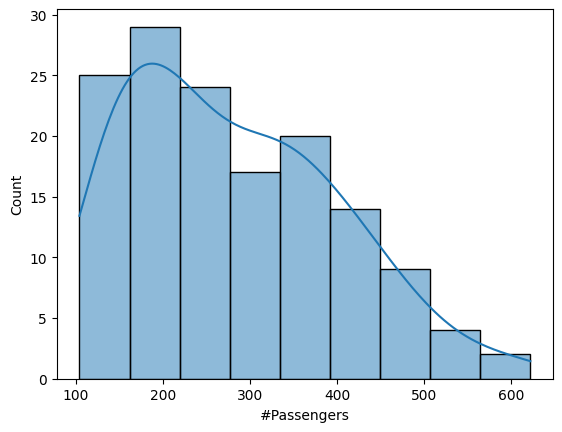

In [14]:
sns.histplot(df['#Passengers'], kde=True);

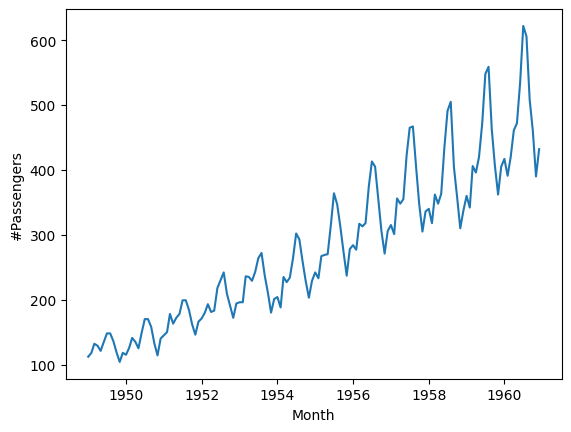

In [15]:
sns.lineplot(df['#Passengers']);

In [16]:
rollmean=df["#Passengers"].rolling(16).mean()

In [17]:
rollstd = df["#Passengers"].rolling(16).std()

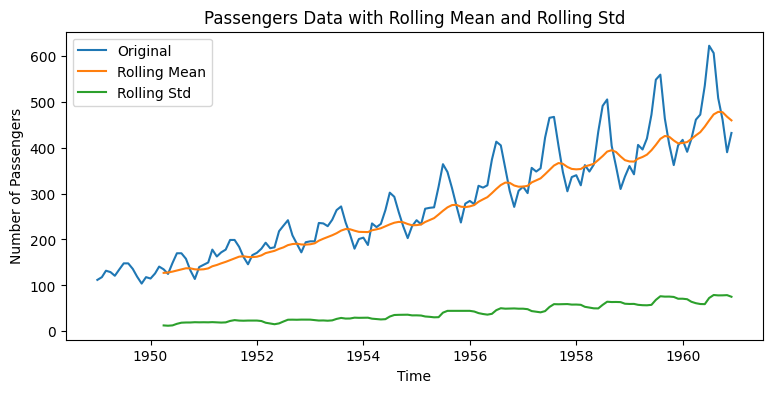

In [18]:
plt.figure(figsize=(9, 4))
plt.plot(df['#Passengers'], label='Original')
plt.plot(rollmean, label='Rolling Mean')
plt.plot(rollstd, label='Rolling Std')
plt.title('Passengers Data with Rolling Mean and Rolling Std')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller
adft=adfuller(df["#Passengers"])

In [20]:
pd.Series(adft[0:4],index=["test stats","p-value","lag","data point"])

test stats      0.815369
p-value         0.991880
lag            13.000000
data point    130.000000
dtype: float64

**As p value>0.5, its a stationary modal**

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df["#Passengers"],model= "multiplicative",period=24)

<Figure size 2000x1000 with 0 Axes>

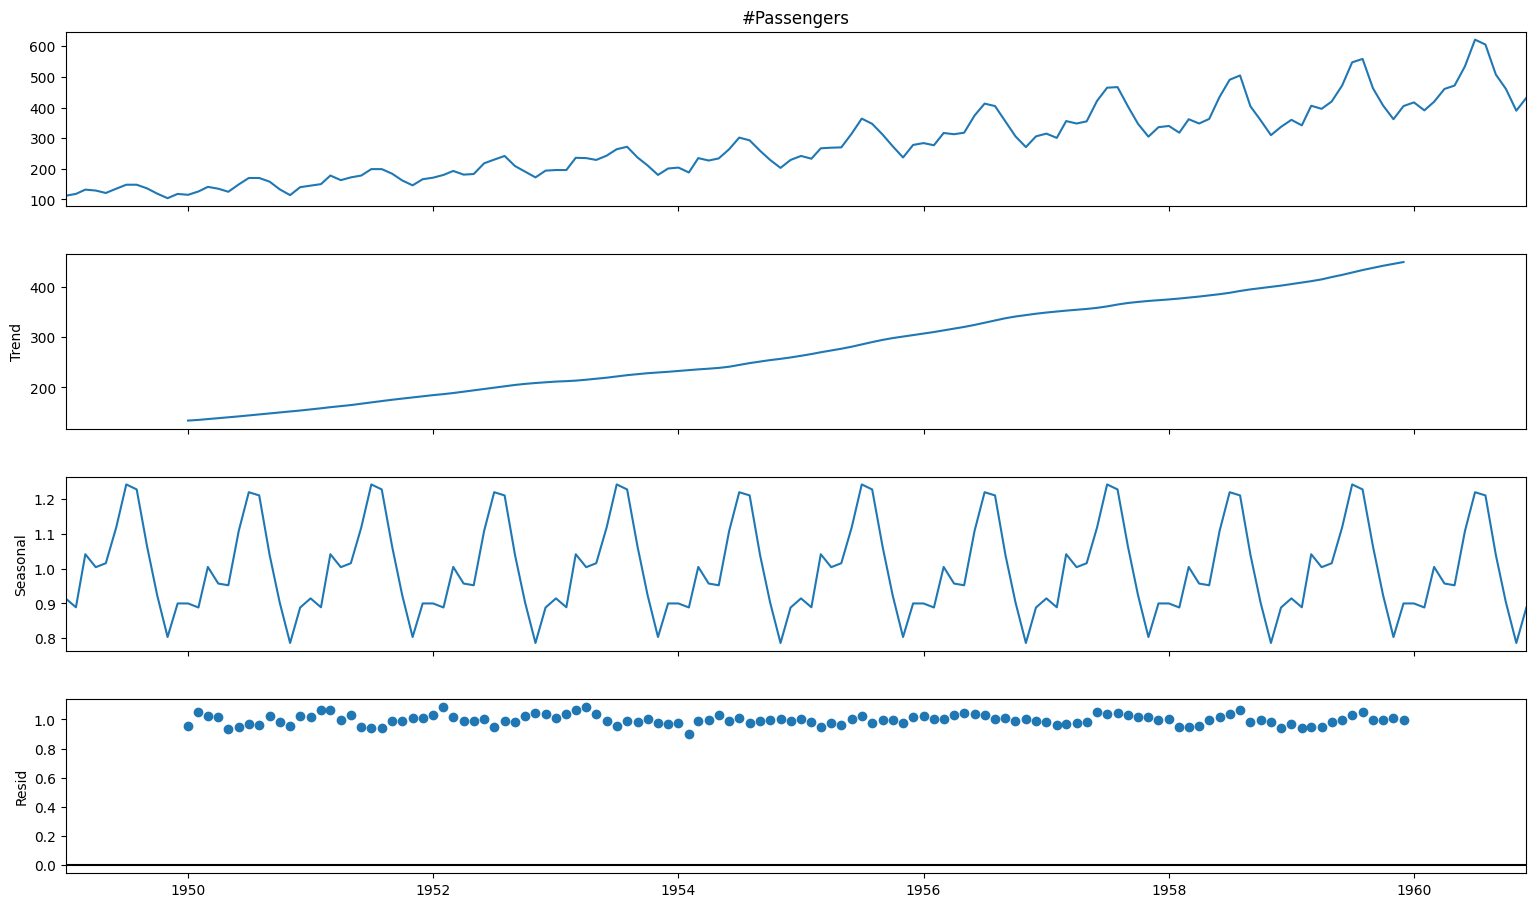

In [22]:
plt.figure(figsize=(20,10))
fig=result.plot()
fig.set_size_inches(17,10)

In [23]:
result.seasonal

Month
1949-01-01    0.914538
1949-02-01    0.889032
1949-03-01    1.041302
1949-04-01    1.004165
1949-05-01    1.015476
                ...   
1960-08-01    1.210174
1960-09-01    1.039321
1960-10-01    0.902993
1960-11-01    0.786557
1960-12-01    0.888226
Name: seasonal, Length: 144, dtype: float64

In [24]:
result.resid

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: resid, Length: 144, dtype: float64

In [25]:
result.trend

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: trend, Length: 144, dtype: float64

<Axes: >

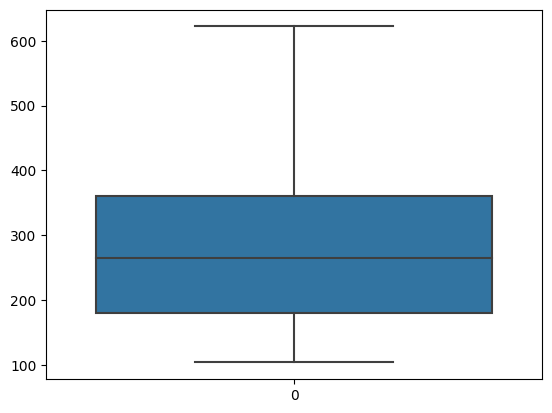

In [26]:
sns.boxplot(df["#Passengers"])

**ACF and PACF Graph**

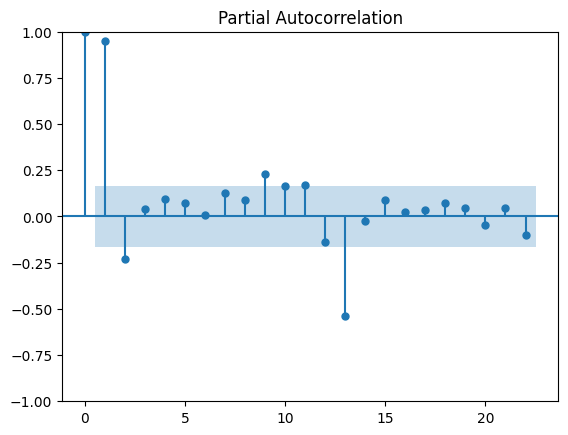

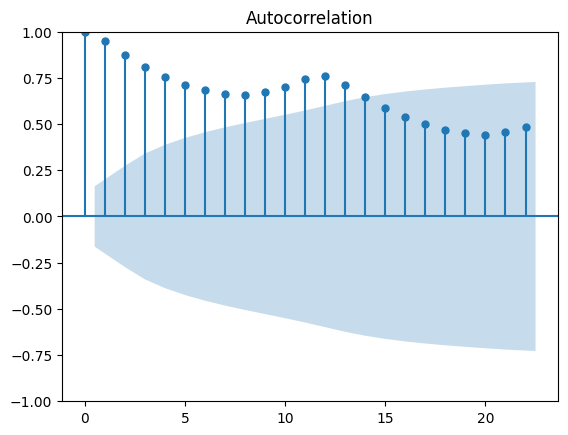

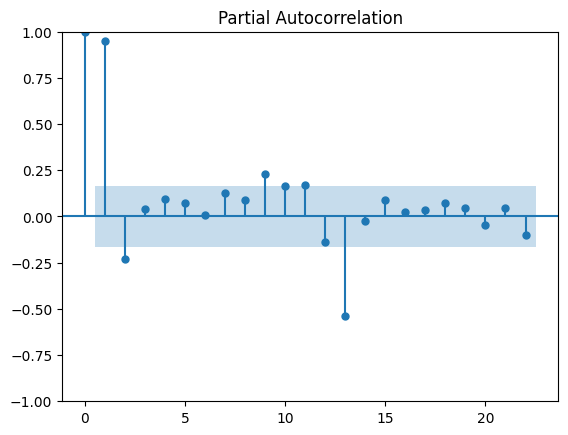

In [27]:
plot_acf(df["#Passengers"])
plot_pacf(df["#Passengers"])

In [28]:
#diffrentiating with 1st value
df["#Passengers"].diff(1)

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Name: #Passengers, Length: 144, dtype: float64

In [29]:
#Train-test Split
train_data=df["#Passengers"][0:-24]
test_data=df["#Passengers"][-24:]

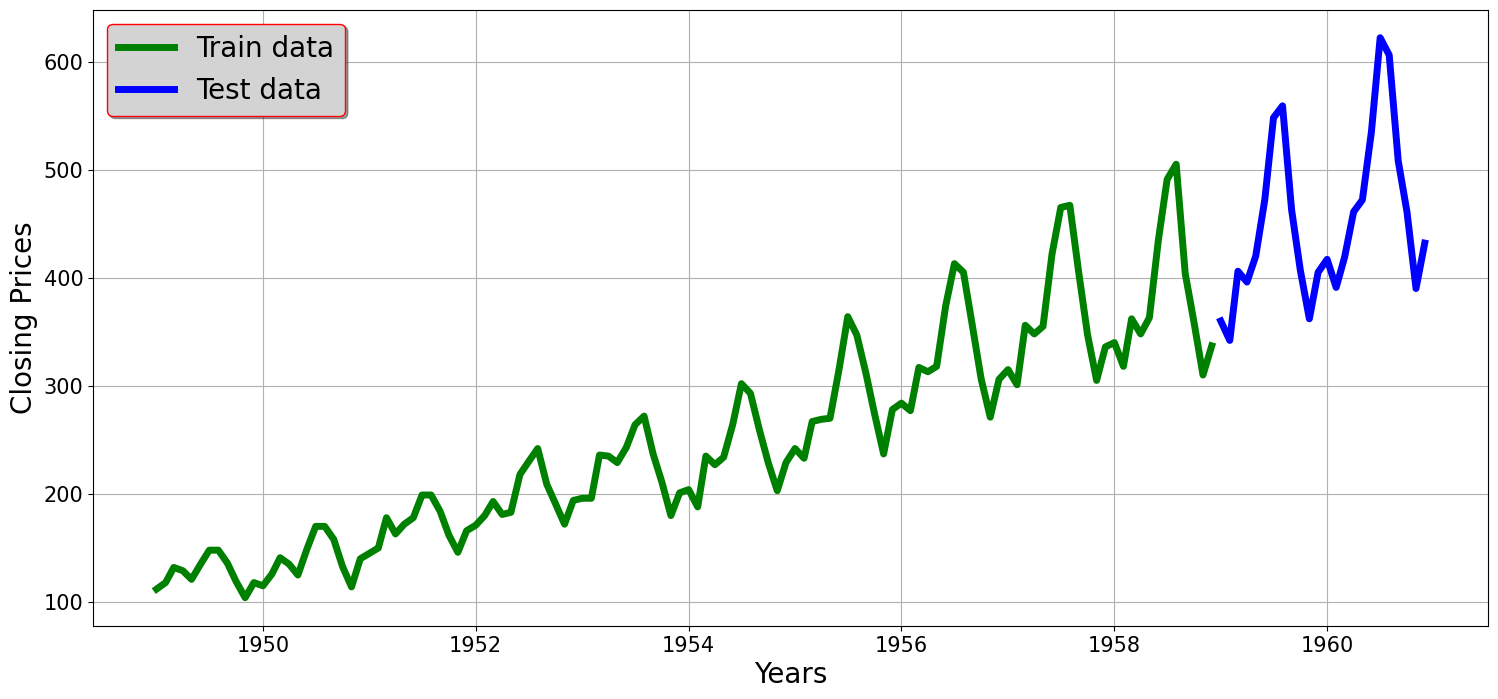

In [30]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Closing Prices', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.plot(train_data, 'green', label='Train data', linewidth = 5)
plt.plot(test_data, 'blue', label='Test data', linewidth = 5)
plt.legend(fontsize = 20, shadow=True,facecolor='lightgrey',edgecolor = 'r');

# Check for stationary test

In [31]:
#Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(48).mean() # rolling mean
    rolstd = timeseries.rolling(48).std() # rolling standard deviation
    # Plot rolling statistics:
    plt.figure(figsize = (18,8))
    plt.grid('both')
    plt.plot(timeseries, color='blue',label='Original', linewidth = 3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [32]:
df_Passengers=df["#Passengers"]
Passengers_diff_1=df_Passengers.diff(1)
Passengers_diff_1 = Passengers_diff_1.dropna()

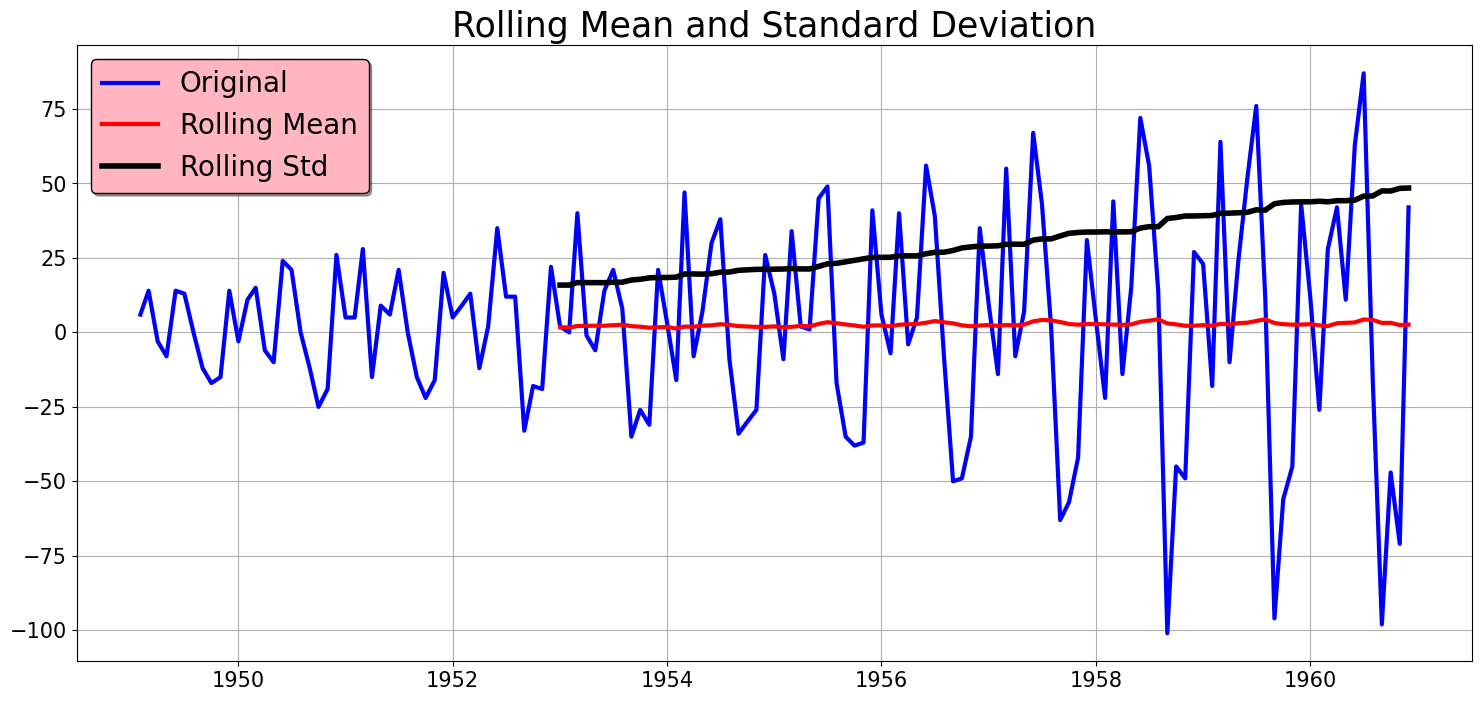

Results of dickey fuller test
Test Statistics                 -2.829267
p-value                          0.054213
No. of lags used                12.000000
Number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64


In [33]:
test_stationarity(Passengers_diff_1)

# ARIMA Model

In [34]:
history=[x for x in train_data]

In [35]:
model=ARIMA(history,order=(1,1,1))

In [36]:
model=model.fit()

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -559.714
Date:                Fri, 15 Nov 2024   AIC                           1125.429
Time:                        10:58:32   BIC                           1133.766
Sample:                             0   HQIC                          1128.814
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5120      0.148     -3.469      0.001      -0.801      -0.223
ma.L1          0.8746      0.097      8.977      0.000       0.684       1.066
sigma2       709.3300     83.383      8.507      0.000     545.903     872.757
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 3.60
Prob(Q):                              0.69   Prob(JB):                         0.16
Heteroskedasticity (H):               6.95   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
def train_arima_model(X, y, arima_order):
    # prepare training dataset
    # make predictions list
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

In [39]:
# evaluate different combinations of p, d and q values for an ARIMA model to get the best order for ARIMA Model
def evaluate_models(dataset, test, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = train_arima_model(dataset, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [40]:
# evaluate parameters
import warnings
warnings.filterwarnings('ignore')
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(train_data, test_data, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=203.389
ARIMA(0, 0, 1) RMSE=113.128
ARIMA(0, 0, 2) RMSE=76.733
ARIMA(0, 1, 0) RMSE=51.782
ARIMA(0, 1, 1) RMSE=48.394
ARIMA(0, 1, 2) RMSE=50.101
ARIMA(0, 2, 0) RMSE=59.368
ARIMA(0, 2, 1) RMSE=51.862
ARIMA(0, 2, 2) RMSE=48.506
ARIMA(1, 0, 0) RMSE=52.404
ARIMA(1, 0, 1) RMSE=48.936
ARIMA(1, 0, 2) RMSE=50.414
ARIMA(1, 1, 0) RMSE=49.127
ARIMA(1, 1, 1) RMSE=47.895
ARIMA(1, 1, 2) RMSE=46.685
ARIMA(1, 2, 0) RMSE=59.043
ARIMA(1, 2, 1) RMSE=49.235
ARIMA(1, 2, 2) RMSE=47.983
ARIMA(2, 0, 0) RMSE=49.485
ARIMA(2, 0, 1) RMSE=48.515
ARIMA(2, 0, 2) RMSE=48.274
ARIMA(2, 1, 0) RMSE=48.450
ARIMA(2, 1, 1) RMSE=44.735
ARIMA(2, 1, 2) RMSE=43.140
ARIMA(2, 2, 0) RMSE=57.762
ARIMA(2, 2, 1) RMSE=48.555
ARIMA(2, 2, 2) RMSE=48.057
Best ARIMA(2, 1, 2) RMSE=43.140


In [41]:
predictions = list()
history = [x for x in train_data]
for t in range(len(test_data)):
    model = ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test_data[t])    

# Comparision of Test data and predicted data

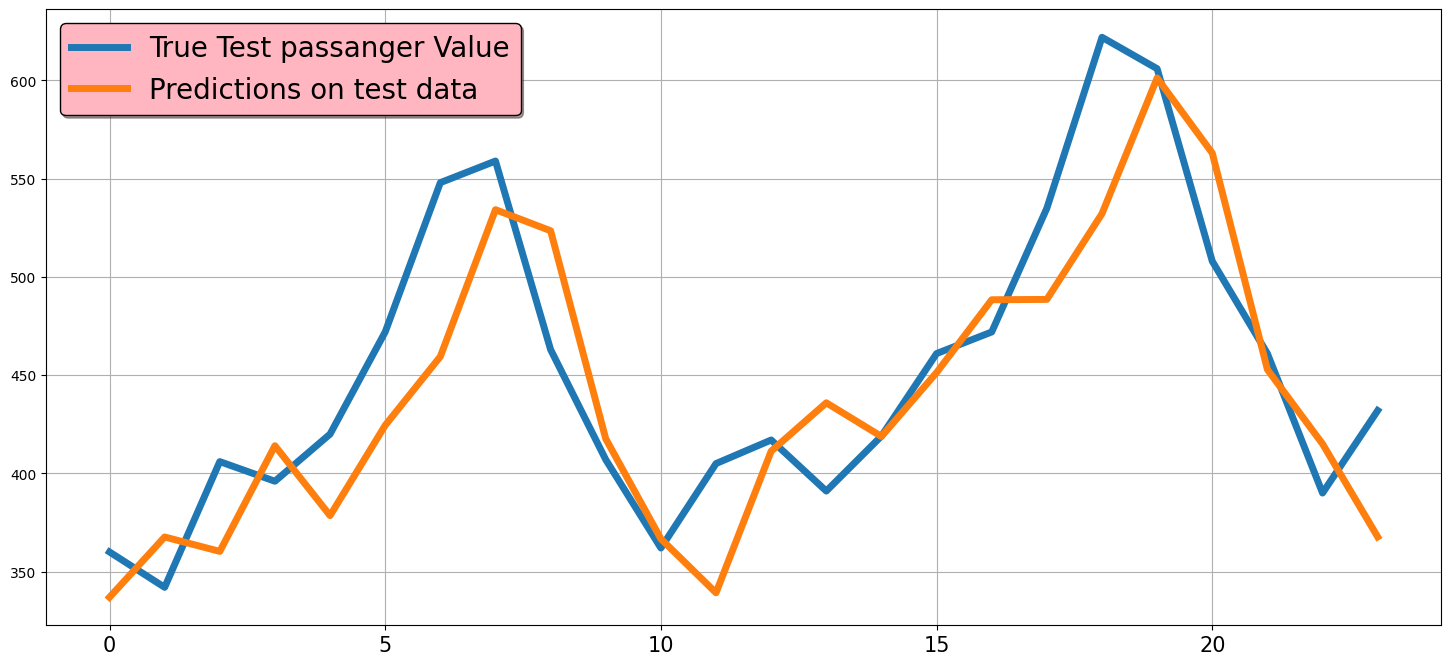

In [42]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'True Test passanger Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions on test data', linewidth = 5)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

# ARIMA Forecast

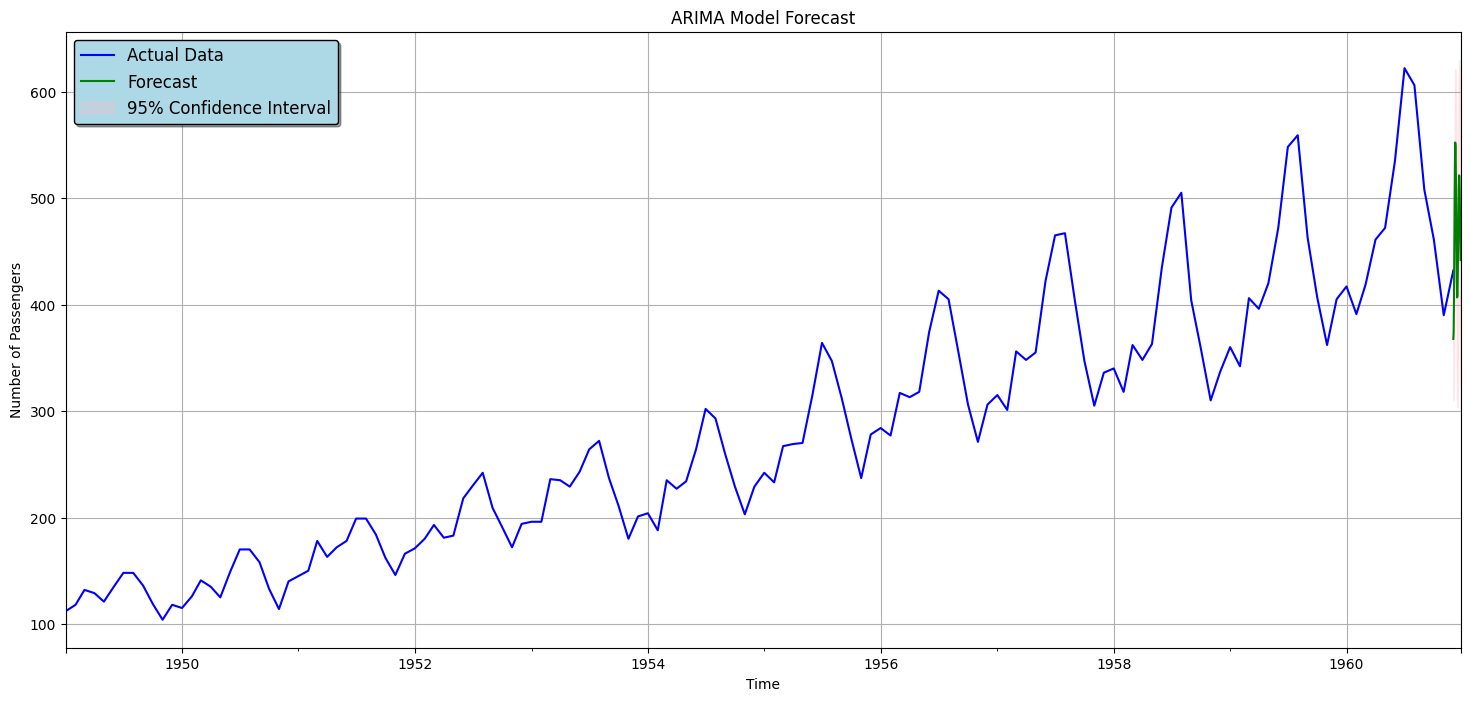

In [43]:
# Generate forecasts
forecast_steps = 24 
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps)
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
conf_int = forecast.conf_int()

# Plot the results
fig, ax = plt.subplots(figsize=(18, 8))

# Plot the historical data
df['#Passengers'].plot(ax=ax, label='Actual Data', color='blue')

# Plot the forecasted data
forecast_series.plot(ax=ax, label='Forecast', color='green')

# Plot the confidence intervals
ax.fill_between(forecast_series.index,
                conf_int[:, 0],
                conf_int[:, 1], color='pink', alpha=0.3)

# Customize the plot
plt.title('ARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.legend(['Actual Data', 'Forecast', '95% Confidence Interval'], fontsize=12, shadow=True, facecolor='lightblue', edgecolor='k')
plt.show()

# SARIMA

In [44]:
model = SARIMAX(train_data, order=(2,1,2), seasonal_order=(2,1,0,12))

In [45]:
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31916D+00    |proj g|=  5.99452D-02


 This problem is unconstrained.



At iterate    5    f=  3.31020D+00    |proj g|=  1.55452D-02

At iterate   10    f=  3.30846D+00    |proj g|=  8.82720D-03

At iterate   15    f=  3.30786D+00    |proj g|=  2.46663D-03

At iterate   20    f=  3.30720D+00    |proj g|=  1.18034D-02

At iterate   25    f=  3.30473D+00    |proj g|=  8.93243D-03

At iterate   30    f=  3.30310D+00    |proj g|=  4.57107D-03

At iterate   35    f=  3.30251D+00    |proj g|=  1.46768D-03

At iterate   40    f=  3.30246D+00    |proj g|=  4.26974D-04

At iterate   45    f=  3.30246D+00    |proj g|=  9.91414D-05

At iterate   50    f=  3.30245D+00    |proj g|=  5.32332D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         #Passengers   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 12)   Log Likelihood                -396.295
Date:                             Fri, 15 Nov 2024   AIC                            806.589
Time:                                     10:59:45   BIC                            825.299
Sample:                                 01-01-1949   HQIC                           814.174
                                      - 12-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3096      0.379      0.818      0.413      -0.432       1.052
ar.L2          0.5021      0.334      1.503      0.133      -0.153       1.157
ma.L1         -0.6333      2.049     -0.309      0.757      -4.649       3.382
ma.L2         -0.3664      0.931     -0.394      0.694      -2.191       1.458
ar.S.L12      -0.0331      0.100     -0.330      0.741      -0.230       0.164
ar.S.L24       0.1412      0.116      1.220      0.222      -0.086       0.368
sigma2        94.3216    196.990      0.479      0.632    -291.772     480.415
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.34
Prob(Q):                              0.99   Prob(JB):                         0.31
Heteroskedasticity (H):               1.58   Skew:                            -0.09
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
start = 0
end = len(train_data)-1
train_prediction = results.predict(start, end)

<Axes: >

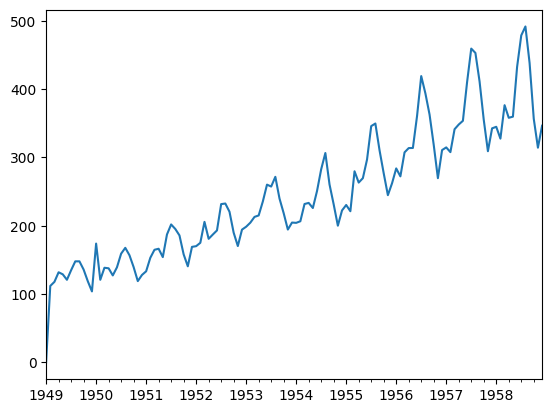

In [47]:
train_prediction.plot()

In [48]:
start = len(train_data)
end = len(df)-1
prediction = results.predict(start, end).rename('prediction')

# Train prediction vs Train data

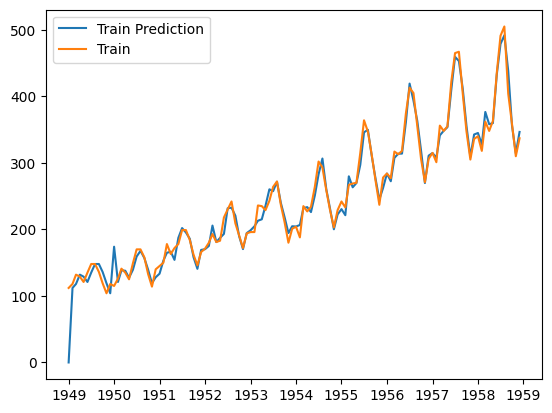

In [49]:
plt.plot(train_prediction, label='Train Prediction')
plt.plot(train_data, label='Train')
plt.legend()
plt.show()

In [50]:
start = len(train_data)
end = len(df)-1
prediction = results.predict(start, end).rename('prediction')

<Axes: xlabel='Month'>

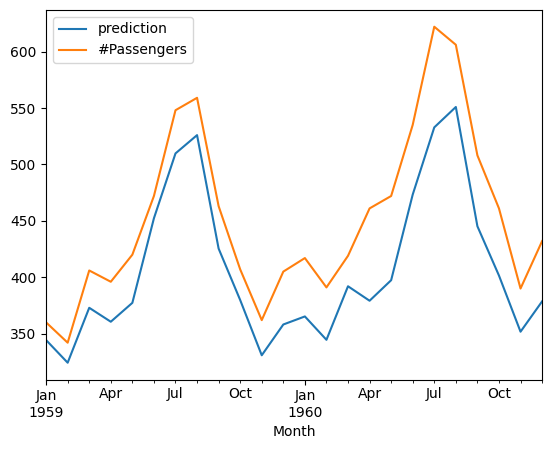

In [51]:
prediction.plot(legend=True)
test_data.plot(legend=True)

In [52]:
#Check model accuracy
train_score = math.sqrt(mean_squared_error(train_data, train_prediction))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_data, prediction))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 15.23 RMSE
Test Score: 48.92 RMSE


In [53]:
#Forecast
forecast = results.predict(start = len(df), end = (len(df)-1)+5*12,
                           typ = 'levels').rename('forecast')

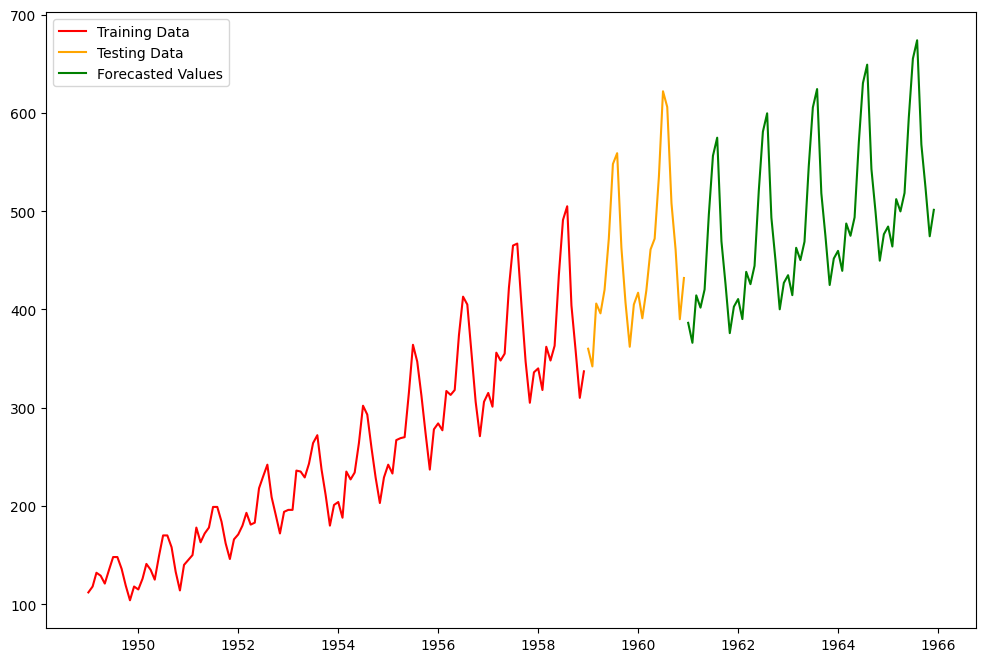

In [54]:
plt.figure(figsize=(12,8))
plt.plot(train_data, label='Training Data',color='red')
plt.plot(test_data, label='Testing Data',color='orange')
plt.plot(forecast, label='Forecasted Values',color='green')
plt.legend()
plt.show()